In [16]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import IPython.display as ipd

## Загрузка аудио файла

In [17]:
speech_file = "audio/man_speech.wav"

Прослушаем исходный аудио файл:

In [18]:
ipd.Audio(speech_file)

In [19]:
y, sr = librosa.load(speech_file)
print('Audio Length:', len(y))
print('Sampling Rate:', sr)

Audio Length: 189440
Sampling Rate: 22050


## Кодирование с линейным предсказанием 

Разделим сигнал на небольшие части для вычисления коэффициентов предсказания. Части должны быть достаточно малы, чтобы показать примерно постоянную статистику. При кодировании речи эти фрагменты обычно имеют длину 20 мс, и этот подход называется кодированием с линейным предсказанием (LPC). Коэффициенты прогнозирования вычисляются обычно каждые 20 мс, а затем передаются вместе с ошибкой прогнозирования от кодера к декодеру.

Такой подход имеет преимущество — не требуются обучающие выборки, коэффициенты вычисляются на основе фактических выборок в текущем блоке.

In [20]:
samples = int(sr * 0.02)
print('Samples: ', samples)

Samples:  441


Сигнал дискретизируется с частотой 22050 Гц, поэтому блок длительностью 20 мс содержит 441 семпл.

In [21]:
L = 10                                     # длина предиктора
length = len(y)                            # длина временного ряда аудио файла
e = np.zeros(len(y))                       # инициализация ошибки предсказания
blocks = int(np.floor(length / samples))   # количество блоков
state = np.zeros(L)                        # состояние памяти фильтра предсказания
h = np.zeros((blocks, L))                  # инициализация памяти коэффициентов предсказания

for m in range(0, blocks):
    A = np.zeros((samples - L, L))         # используем samples-L, чтобы избежать нулей в матрице А
    for n in range(0, samples - L):
        A[n, :] = np.flipud(y[m * samples + n + np.arange(L)])

    # Опеределим сигнал d на одну выборку в будущее:
    d = y[m * samples + np.arange(L, samples)]
    
    # Построим фильтр предсказания:
    h[m, :] = np.dot(np.dot(np.linalg.pinv(np.dot(A.transpose(), A)), A.transpose()), d)
    hperr = np.hstack([1, -h[m, :]])
    e[m * samples + np.arange(0, samples)], state = sp.lfilter(hperr, [1], y[m * samples + np.arange(0, samples)], zi=state)  

In [22]:
print ("The average squared error: ", np.dot(e.transpose(), e) / len(e))
print ("The mean squared signal power: ", np.dot(y.transpose(), y) / len(y))
print ("The Signal to Error ratio: ", np.dot(y.transpose(), y) / np.dot(e.transpose(),e))

The average squared error:  2.167651206699195e-05
The mean squared signal power:  0.0020479962632462784
The Signal to Error ratio:  94.479972465906


Прослушаем ошибку предсказания:

In [23]:
ipd.Audio(e, rate=sr)

Построим график сигнала и ошибки предсказания:

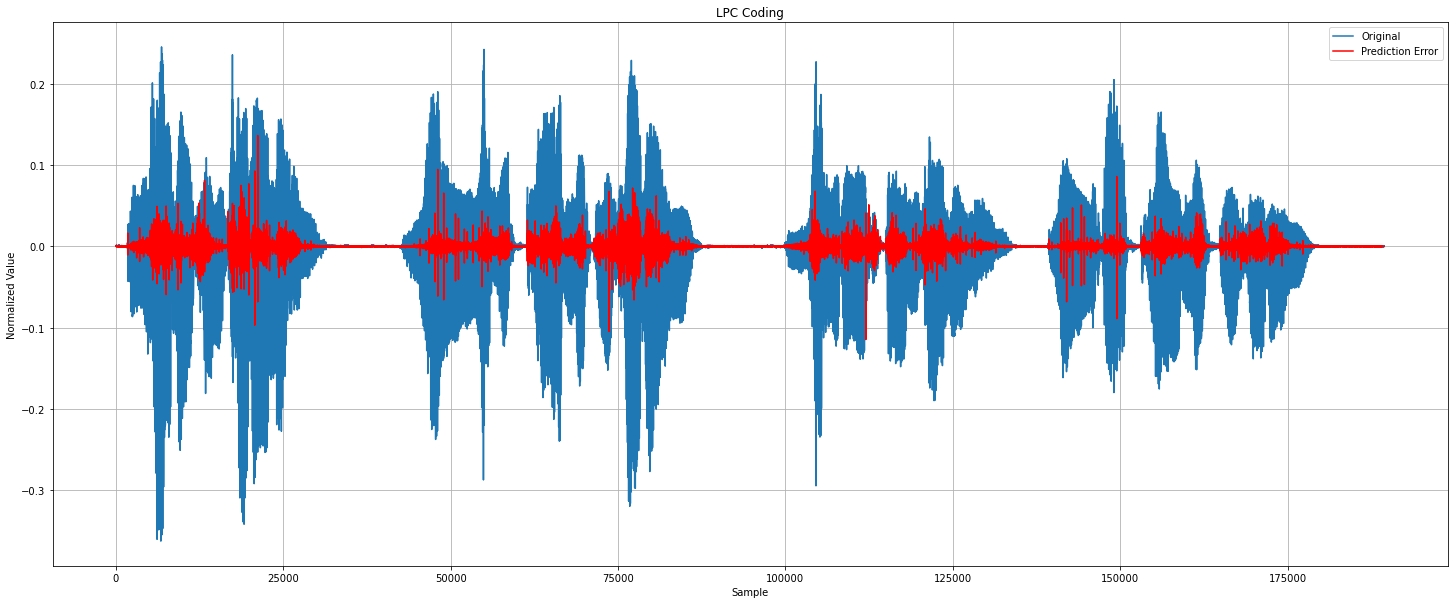

In [24]:
plt.figure(figsize=(25, 10))

plt.plot(y)
plt.plot(e, 'r')

plt.xlabel('Sample')
plt.ylabel('Normalized Value')
plt.legend(('Original', 'Prediction Error'))
plt.title('LPC Coding')

plt.grid()

Реконструируем сигнал:

In [25]:
xrek = np.zeros(y.shape)          # инициализация реконструированной памяти сигнала
state = np.zeros(L)               # инициализация состояния памяти фильтра предсказания

for m in range(0, blocks):
    hperr = np.hstack([1, -h[m, :]])
    
    # Построим фильтр реконструкции:
    xrek[m * samples + np.arange(0, samples)], state = sp.lfilter([1], hperr, e[m * samples + np.arange(0, samples)], zi = state)

Прослушаем реконструированный сигнал:

In [26]:
ipd.Audio(xrek, rate=sr )